# **Reward Type Differences in 2048**
Thomas Hopkins

## **Reward Types**
Here are the 3 different reward types currently offered in Env2048:
1. `score`
    - Uses the normal score from the original game.
    - This is the sum of all tiles created by merging that occurred after an action.
    - Example: If two 8 tiles are merged after an action, then the reward is +16.
2. `survival`
    - Moves that change the current state have reward +1.0.
    - Moves that don't change the current state have reward -0.1.
    - Moves that cause game over have reward 0.0.
3. `milestone`
    - Moves that reach a never before seen tile have reward +10.0
    - All other moves have reward 0.0.

## **Learning Algorithm**
We will use Vanilla Policy Gradient (with GAE-Lambda).

## **Experiments**
We will train a new VPG model on each type of environment for 10,000 games.

The parameters used for the model may differ for each reward type since some rewards are sparser than others.

Plotting the reward-per-episode curves should give us an idea of which reward type is ideal.

In [2]:
import torch
import torch.nn.functional as F
from torch import nn
import scipy.signal
from torch.distributions.categorical import Categorical
from env2048.env import Env2048
import matplotlib.pyplot as plt
import numpy as np
from torch.optim import Adam
from torch.optim.lr_scheduler import LambdaLR
from tqdm import tqdm


def add_length_to_shape(length, shape=None):
    '''
    Combines an arbitrary shape with a preferred length.
    Parameters
    ----------
    length : int
        size of first axis
    shape : tuple[int], optional
        size of the rest of the axes
    '''
    if shape is None:
        return (length,)
    return (length, shape) if np.isscalar(shape) else (length, *shape)


def discount_cumsum(x, discount):
    return scipy.signal.lfilter([1], [1, float(-discount)], x[::-1], axis=0)[::-1]


class TrajectoryBuffer:
    def __init__(self, obs_shape, action_shape, size, discount=0.99, lam=0.95):
        '''
        Stores the trajectories that the agent takes up to the buffer size.
        It will store for each step in the environment:
            - observation
            - immediate reward
            - action taken
            - probability of selecting that action (according to policy)
            - perceived value of the observation
        When the trajectory is finished it will compute:
            - discounted reward to go
            - discounted lambda advantage
        The buffer can be emptied by calling the `get()` method
        '''
        self.obs_buf = np.zeros(add_length_to_shape(size, obs_shape),
                                dtype=np.float32)
        self.act_buf = np.zeros(add_length_to_shape(size, action_shape),
                                dtype=np.float32)
        self.rew_buf = np.zeros(size, dtype=np.float32)
        self.ret_buf = np.zeros(size, dtype=np.float32)
        self.adv_buf = np.zeros(size, dtype=np.float32)
        self.logp_buf = np.zeros(size, dtype=np.float32)
        self.val_buf = np.zeros(size, dtype=np.float32)

        self.ptr = 0
        self.start_ptr = 0
        self.size = size

        self.discount = discount
        self.lam = lam

    def store(self, obs, action, reward, logp, value):
        ''' Store a single step in the buffer '''
        if self.ptr == self.size:
            print('Cannot store current step. Buffer is full.')
            return
        self.obs_buf[self.ptr] = obs
        self.act_buf[self.ptr] = action
        self.rew_buf[self.ptr] = reward
        self.logp_buf[self.ptr] = logp
        self.val_buf[self.ptr] = value
        self.ptr += 1

    def finish_trajectory(self, last_val=0.0):
        ''' Computes the return and advantage per step in trajactory '''
        path_slice = slice(self.start_ptr, self.ptr)
        rewards = np.append(self.rew_buf[path_slice], last_val)
        values = np.append(self.val_buf[path_slice], last_val)

        # GAE-Lambda advantage
        deltas = rewards[:-1] + self.discount * values[1:] - values[:-1]
        self.adv_buf[path_slice] = discount_cumsum(deltas,
                                                   self.discount * self.lam)
        # Rewards-to-go
        self.rew_buf[path_slice] = discount_cumsum(rewards,
                                                   self.discount)[:-1]
        self.start_ptr = self.ptr

    def get(self):
        ''' Empties the buffer into something useable for learning '''
        if self.ptr != self.size:
            print('ERROR: buffer not full')
            return
        self.ptr = 0
        self.start_ptr = 0
        # advantage normalization (LOOK THIS UP!)
        adv_mean, adv_std = np.mean(self.adv_buf), np.std(self.adv_buf)
        self.adv_buf = (self.adv_buf - adv_mean) / (adv_std + 1e-8)
        data = {'obs': self.obs_buf, 'act': self.act_buf, 'ret': self.ret_buf,
                'adv': self.adv_buf, 'logp': self.logp_buf}
        return {k: torch.as_tensor(v, dtype=torch.float32) for k, v in data.items()}


class MLP(nn.Module):
    def __init__(self, nodes_per_layer, activation='relu'):
        '''
        A basic multi-layered perceptron using PyTorch.
        Parameters
        ----------
        nodes_per_layer : List[int]
            number of nodes per layer in the network
        activation : str, optional
            description of activation to use in between layers
            supports: {'sigmoid', 'relu', 'tanh'}
        '''
        super().__init__()
        activ_func = None
        if activation == 'relu':
            activ_func = nn.ReLU()
        elif activation == 'sigmoid':
            activ_func = nn.Sigmoid()
        elif activation == 'tanh':
            activ_func = nn.Tanh()
        self.mlp = nn.Sequential()
        # game state is 2D tensor but we need 1D tensor
        nodes_per_layer[0] = nodes_per_layer[0] ** 2
        # add layers
        for i in range(1, len(nodes_per_layer)):
            self.mlp.append(nn.Linear(nodes_per_layer[i-1],
                                    nodes_per_layer[i]))
            if activ_func is not None and i != len(nodes_per_layer)-1:
                self.mlp.append(activ_func)

    def forward(self, x):
        if len(x.shape) == 3:
            x = torch.flatten(x, start_dim=1)
        else:
            x = torch.flatten(x)
        return self.mlp(x)


class ActorCriticMLP:
    ''' Actor/Critic that performs actions and makes value estimates '''
    def __init__(self, obs_dim, act_dim):
        self.actor = MLP([obs_dim, 128, 64, act_dim])
        self.critic = MLP([obs_dim, 128, 64, 1])

    def distribution(self, obs, mask=None):
        ''' Returns the current policy distribution over the observation '''
        logits = self.actor(obs)
        if mask is not None:
            logits = logits.masked_fill((1 - mask), float('-inf'))
        return Categorical(logits=logits)

    def policy(self, obs, act=None, mask=None):
        ''' Returns an action given the observation '''
        pi = self.distribution(obs, mask=mask)
        logp_a = None
        if act is not None:
            logp_a = pi.log_prob(act)
        return pi, logp_a

    def value(self, obs):
        ''' Returns the perceived value of the observation '''
        return self.critic(obs)

    def step(self, obs, mask=None):
        ''' Returns the action, value, and logp_a for the observation '''
        pi, _ = self.policy(obs, mask=mask)
        a = pi.sample()
        logp = pi.log_prob(a)
        v = self.value(obs)
        return a.item(), v.item(), logp.item()


class VPG:
    ''' Vanilla Policy Gradient Algorithm '''
    def __init__(self, buffer_size=500, discount=0.99, pi_lr=0.0003, v_lr=0.001, lam=0.97):
        self.buffer_size = buffer_size
        self.discount = discount
        self.pi_lr = pi_lr
        self.v_lr = v_lr
        self.lam = lam

    def compute_loss_pi(self, data):
        obs = data['obs']
        act = data['act']
        adv = data['adv']
        logp_old = data['logp']

        pi, logp = self.ac.policy(obs, act=act)
        loss_pi = -(logp * adv).mean()

        return loss_pi

    def compute_loss_val(self, data):
        obs = data['obs']
        ret = data['ret']
        return ((self.ac.value(obs) - ret) ** 2).mean()

    def update(self):
        ''' Updates policy and value parameters via backprop '''
        data = self.buffer.get()

        self.pi_optim.zero_grad()
        pi_loss = self.compute_loss_pi(data)
        pi_loss.backward()
        self.pi_optim.step()

        for i in range(self.train_v_iters):
            self.v_optim.zero_grad()
            v_loss = self.compute_loss_val(data)
            v_loss.backward()
            self.v_optim.step()

    def train(self, env_func, epochs=250, train_v_iters=80):
        ''' Train an agent on the given environment '''
        all_ep_returns = []
        all_ep_scores = []
        env = env_func()
        self.buffer = TrajectoryBuffer(env.observation_space.shape,
                                       env.action_space.shape,
                                       self.buffer_size,
                                       discount=self.discount,
                                       lam=self.lam)
        self.ac = ActorCriticMLP(env.observation_space.shape[0],
                                 env.action_space.n)
        self.train_v_iters = train_v_iters
        self.pi_optim = Adam(self.ac.actor.parameters(), lr=self.pi_lr)
        self.v_optim = Adam(self.ac.critic.parameters(), lr=self.v_lr)
        o = env.reset()
        ep_ret = 0
        ep_len = 0
        action_mask = torch.ones((4,), dtype=int)
        for k in tqdm(range(epochs), total=epochs):
            for t in range(self.buffer_size):
                with torch.no_grad():
                    a, v, logp = self.ac.step(torch.as_tensor(o, dtype=torch.float32),
                                              mask=action_mask)

                next_o, r, done, info = env.step(a)
                action_mask = torch.as_tensor(info['action_mask'])
                ep_ret += r
                ep_len += 1
                
                self.buffer.store(o, a, r, logp, v)
                o = next_o

                buffer_full = t == self.buffer_size - 1

                if done or buffer_full:
                    if buffer_full and not done:
                        with torch.no_grad():
                            _, v, _ = self.ac.step(torch.as_tensor(o, dtype=torch.float32),
                                                   mask=action_mask)
                    else:
                        v = 0.0
                    if done:
                        ep_score = env.score
                        all_ep_returns.append(ep_ret)
                        all_ep_scores.append(ep_score)
                        o = env.reset()
                        ep_ret = 0
                        ep_len = 0
                        action_mask = torch.ones((4,), dtype=int)
                    self.buffer.finish_trajectory(last_val=v)
            self.update()
        return all_ep_returns, all_ep_scores

### `score`

In [4]:
discount = 0.99
lam = 0.97
buffer_size = 512
pi_lr = 0.0003
v_lr = 0.001
train_v_iters = 80
epochs = 100
env_func = lambda : Env2048(size=4, reward_type='score')
score_vpg = VPG(buffer_size=buffer_size, discount=discount, pi_lr=pi_lr, v_lr=v_lr, lam=lam)
score_ep_returns, score_ep_scores = score_vpg.train(env_func, epochs=epochs, train_v_iters=train_v_iters)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:48<00:00,  2.06it/s]


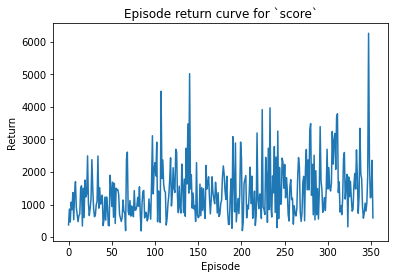

In [5]:
plt.plot(range(len(score_ep_returns)), score_ep_returns)
plt.title('Episode return curve for `score`')
plt.xlabel('Episode')
plt.ylabel('Return')
plt.show()

### `survival`

In [6]:
discount = 0.99
lam = 0.97
buffer_size = 512
pi_lr = 0.0003
v_lr = 0.001
train_v_iters = 80
epochs = 100
env_func = lambda : Env2048(size=4, reward_type='survival')
survival_vpg = VPG(buffer_size=buffer_size, discount=discount, pi_lr=pi_lr, v_lr=v_lr, lam=lam)
survival_ep_returns, survival_ep_scores = survival_vpg.train(env_func, epochs=epochs, train_v_iters=train_v_iters)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:46<00:00,  2.15it/s]


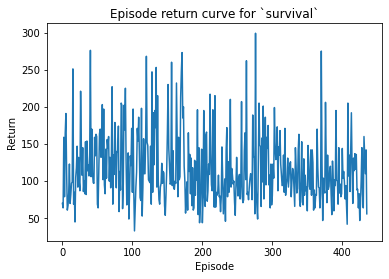

In [7]:
plt.plot(range(len(survival_ep_returns)), survival_ep_returns)
plt.title('Episode return curve for `survival`')
plt.xlabel('Episode')
plt.ylabel('Return')
plt.show()

### `milestone`

In [8]:
discount = 0.99
lam = 0.97
buffer_size = 512
pi_lr = 0.0003
v_lr = 0.001
train_v_iters = 80
epochs = 100
env_func = lambda : Env2048(size=4, reward_type='milestone')
milestone_vpg = VPG(buffer_size=buffer_size, discount=discount, pi_lr=pi_lr, v_lr=v_lr, lam=lam)
milestone_ep_returns, milestone_ep_scores = milestone_vpg.train(env_func, epochs=epochs, train_v_iters=train_v_iters)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:47<00:00,  2.12it/s]


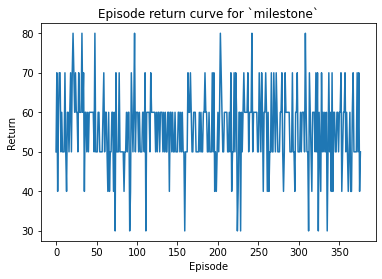

In [9]:
plt.plot(range(len(milestone_ep_returns)), milestone_ep_returns)
plt.title('Episode return curve for `milestone`')
plt.xlabel('Episode')
plt.ylabel('Return')
plt.show()

## **Results**
Here is a plot of game scores. This is the best way to compare methods since episode lengths can be arbitrarily long if the same action that doesn't change state is repeated forever.

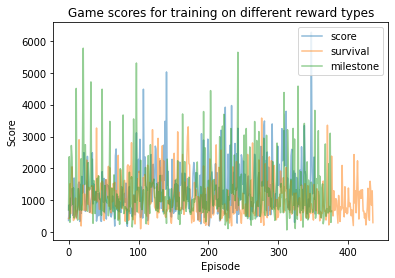

In [10]:
plt.plot(range(len(score_ep_scores)), score_ep_scores, label='score', alpha=0.5)
plt.plot(range(len(survival_ep_scores)), survival_ep_scores, label='survival', alpha=0.5)
plt.plot(range(len(milestone_ep_scores)), milestone_ep_scores, label='milestone', alpha=0.5)
plt.title('Game scores for training on different reward types')
plt.xlabel('Episode')
plt.ylabel('Score')
plt.legend()
plt.show()